In [1]:
import numpy as np
from IPython.display import clear_output
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D

from PIL import Image
from scipy.optimize import minimize
import f_class
from GP import GP
from GP_grad import GP_grad
from localGD import localGD
import time
import imageio
from torch.quasirandom import SobolEngine
import sobol_seq
from utils import *
import numdifftools as nd

#### Noiseless & Noisy

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and y, rememeber to scale the noise as well'''

'If use the scaled X and y, rememeber to scale the noise as well'

#### High-dimensional function $f$

In [3]:
objective = f_class.Hartmann_6(Noise, Noise_level)

# objective = f_class.Alpine(Noise, Noise_level) 
objective = f_class.Ackley(Noise, Noise_level)
# objective = f_class.Ackley_2(Noise, Noise_level)
# objective = f_class.Shubert_2(Noise, Noise_level)
# objective = f_class.Michalewicz(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level, dim=20)
# objective = f_class.Rosenbrock(Noise, Noise_level)
# objective = f_class.Griewank(Noise, Noise_level)
# objective = f_class.Levy(Noise, Noise_level, dim=10) 
# objective = f_class.Rastrigin(Noise, Noise_level, dim=10)

f = objective.func
clean_f = lambda x: f_class.Hartmann_6().func(x)
# clean_f = lambda x: f_class.Alpine().func(x)
clean_f = lambda x: f_class.Ackley().func(x)
# clean_f = lambda x: f_class.Ackley_2().func(x)
# clean_f = lambda x: f_class.Shubert_2().func(x)
# clean_f = lambda x: f_class.Michalewicz().func(x)
# clean_f = lambda x: f_class.Schwefel(dim=20).func(x)
# clean_f = lambda x: f_class.Rosenbrock().func(x)
# clean_f = lambda x: f_class.Griewank().func(x)
# clean_f = lambda x: f_class.Levy(dim=10).func(x)
# clean_f = lambda x: f_class.Rastrigin(dim=10).func(x)
B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(B) 
lb = B[:, 0]; ub = B[:, 1]


dim = objective.input_dim
print('dim: ', dim)
# print(f( np.array([dim*[1], dim*[1]])))

[[-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]
 [-0.5  2. ]]
dim:  20


#### Finding Optimized Hyperparameter $\sigma, \ell \rightarrow$ Online Update of Hyperparameter

In [4]:
# set seed
seed = 0
def random_draw(n_random_draws=3):
    """ samples some points"""
    # should draw randomly
    return np.random.uniform(lb, ub, size=(n_random_draws, dim))


def optimize_hyper(lb, ub, sample_size=2000):
#     np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [5]:
# # find optimized hyper, if online, skip this part
# gp = GP_grad(B, Noise, Noise_level)
# (ls, var) = optimize_hyper(lb, ub, sample_size=2000)
# del gp
# (ls, var)

### Grid

In [6]:
# n_Grid = dim
# G = np.zeros((dim, n_Grid))
# for i in range(dim):
#     G[i] = np.linspace(lb[i], ub[i], n_Grid)

# Grid = np.vstack( [axis.flatten() for axis in np.meshgrid(*(G[i] for i in range(G.shape[0])))] ).T
# Grid.shape

### Grid Approx Gradient

In [7]:
# # approximate the gradient
# from scipy import optimize

# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape

In [8]:
# # 3d plot of the gradient
# # approximate the gradient
# from scipy import optimize

# # optimize.approx_fprime(x, clean_Ackley_1d, eps)
# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape
# g1 = approx_grad[:, 0]
# g2 = approx_grad[:, 1]
# g1, g2

# BO

In [9]:
MAX = 300 # function observations

## Gradient-based Method

##### 1. Setup

In [10]:
# initial data
setup = 5
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))

# sample from a small 2d box
# Xc = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
# X = close_draw(Xc, n_random_draws=setup)

# X = np.vstack([X, np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))])

In [11]:
gp = GP_grad(B, Noise, Noise_level, compress=True)
# gp.set_hyper(ls, var)  # if online, skip

gp.set_data(X, f(X))
ls, var = gp.optimize()
gp.set_hyper(ls, var)
gp.fit()

# w: starting point of GD
# w = X[0].reshape(1, dim)
history = [(w, f(w)) for w in X]

In [12]:
w = X[0].reshape(1, dim)
gp.posterior(w), gp._normal(f(w))

((array([[0.95879156]]), array([[1.00000118e-08]])), array([0.95879157]))

##### 2. Warm up

In [13]:
# gp.posterior_full_grad('full', dim*[w]), gp.posterior_grad(w)
# warmup = 30
# history_warmup = []
# for i in range(1, warmup+1):
#     b = np.log(i)
#     w, fw = gp.ucb_minimize(b)
#     X = np.vstack([X, w])
    
#     print(i, end = ', ')
#     print('w: ', w, end = ', ')
#     print('f(w): ', f(w).item(), end = ', ')
#     print()
    
#     gp.add_data(w.reshape(1, dim), f(w))
    
#     if i % 5 == 0:
#         ls, var = gp.optimize()
#         print('  # Optimal (ls, var) = ', (ls, var))
#     gp.fit()
#     history.append( (w, f(w)) )
    
# X_fix = X

In [14]:
# gp.posterior_full_grad('full', dim*[w]), gp.posterior_grad(w)
warmup = 1
for i in range(1, warmup+1):
    w = gp.thompson_sample(n_mesh=gp.dim*100)
    gp.add_data(w.reshape(1, dim), f(w))
    if i % 5 == 0:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()    
                
    X = np.vstack([X, w])
    print(i, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    history.append( (w, f(w)) )
    
X_fix = X

1, w:  [ 0.88721034 -0.05880638  1.61078405  0.87337714  1.20628667  0.47926833
  0.21609944  1.05796245  1.90057245  0.7335597  -0.17339247  1.54681233
  1.71070796  1.78393942  1.58671004  1.47513878  0.44144233  0.96088123
  1.33929116 -0.38181568], f(w):  5.936026810920055, 


In [15]:
gp.get_normal()

(5.436751097592101, 0.267423480164939)

##### 3. Optimize via GD

In [16]:
GD = localGD(gp, B, w, f)

from scipy import optimize
eps = np.sqrt(np.finfo(float).eps)
gp.grad(w), gp.grad_sample(w), optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

(array([[ 5.38373620e-11, -1.89956314e-11, -8.90558488e-11,
         -2.80280558e-11, -5.59588122e-11, -1.95820615e-11,
          1.26597494e-11,  1.71524294e-12, -9.71151031e-12,
         -5.56907426e-11, -4.42336570e-12, -1.96166009e-11,
         -2.47619214e-11, -5.96282262e-11, -6.12795326e-11,
          1.41191932e-11,  5.50418575e-11,  2.62292872e-12,
         -2.98382851e-13,  4.08879128e-11]]),
 array([[ 1.78045924,  0.55319641, -0.62957252,  0.58607408,  3.4789584 ,
          1.11321607, -2.5203391 ,  2.67943819,  4.75975205,  3.20429312,
         -1.89647107,  3.44162012,  1.89752666,  1.44558283,  1.09787715,
         -2.40616262,  2.96536243,  4.50055459, -0.60402516,  2.34571737]]),
 array([-0.0761435 , -0.11671281,  0.02451611, -0.09712195,  0.45287037,
         0.10387492,  0.32356739,  0.25021863,  0.08063817, -0.20045948,
        -0.29038286,  0.12167764, -0.06090999, -0.05332518,  0.05829382,
         0.24616218,  0.16797185,  0.05654216,  0.43596077, -0.25523925]))

In [17]:
gp.optimize()
gp.fit()
np.set_printoptions(precision=4)
cost = setup + warmup
y_best = np.min(f(gp.X))

# create a candidate list of GD points from all queried points so far
GD_House = [localGD(gp, B, w, f) for w in gp.X]

In [18]:
import time
import random
ts_count = 0

GD_FAIL = 0
MAX_GD_FAIL = 5

M = 1

while cost <= MAX:
    # print out y_best, cost
    y_best = np.min(f(gp.X))
    arg_y_best = np.argmin(f(gp.X))
    print(cost, end = '. ')
    
    # active local GD-M
    GD_cand = sorted(filter(lambda x: x.STOP >= x.FAIL, GD_House), key=lambda x: x.min)[:M]
    GD_cand_No = [GD_House.index(cand) for cand in GD_cand]

    # add back the y_best GD
#     TopMSoFar = sorted(GD_House, key=lambda x: x.min)[:1]
#     y_best_No = [GD_House.index(T) for T in TopMSoFar]
#     for i in y_best_No:
#         if i not in GD_cand_No:
#             print('add the top 2 GD', i)
#             GD_House[i].FAIL = 1
#             GD_House[i].STOP = 1
#             GD_cand_No.insert(0, i)
#             GD_cand.insert(0, GD_House[i])
            
    All_GD_path = []
    
    # pick GD via lowest UCB
    min_UCB = np.inf
    best_GD_No = np.inf
    
    for i in GD_cand_No:
        w, GD_path = GD_House[i].update(commit=False)
        All_GD_path.append(GD_path)

        eta = 0 # np.abs(1e-3 * GD_House[i].min)
        path_UCB = np.mean([gp.EI(inner_w, GD_House[i].min - eta) for inner_w in GD_path])
        
        # best
        if path_UCB < min_UCB:
            min_UCB = path_UCB
            best_W = w
            best_GD_No = i

    if GD_FAIL < MAX_GD_FAIL and len(GD_cand) >= M:
        best_GD = GD_House[best_GD_No]
        print('GD Query > ', GD_cand_No)
        print('    Pick GD No, PrevLoops, PrevMin = ', (best_GD_No, len(best_GD.history_full_w), best_GD.min.item()))
        w = best_W
              
        # update the picked GD 
        print('    Forward Steps = ', len(All_GD_path[GD_cand_No.index(best_GD_No)]) )
        best_GD.commit(w, All_GD_path[GD_cand_No.index(best_GD_No)])
        
        if f(w) < y_best:
            GD_FAIL = 0
        else:
            GD_FAIL += 1  
    else:
        # Option 2: thompson_sample
        w = gp.thompson_sample(n_mesh=4000)
        ts_count += 1
        print('Thompson Query > ', ts_count)
        GD_House.append(localGD(gp, B, w, f))
        print('add in the new thompson point', GD_House.index(GD_House[-1]))
        GD_FAIL = 0

   
    print('    Normal f(w): %.4f ' % gp._normal(f(w).item()) )
    print('    Predict f(w): (%.4f, %.4f) ' % gp.posterior(w))
    gp.add_data(w.reshape(1, -1), f(w))
    cost += 1
        
    # online hyper udpate + fitting GP with new query w
    ls, var = gp.optimize()
    gp.set_hyper(ls, var)
    print('  # Optimal (ls, var) = (%.4f, %.4f)' % (ls, var))
    gp.fit()
    
    history.append( (w, f(w)) )
    m, v = gp.posterior_full_grad('full', dim*[w])
    v = np.sqrt(np.diag(v))
    print('    w: ', np.squeeze(w), end = ', ')
    print('    f(w): %.4f ' % f(w).item())
    print('    d(w): ', np.squeeze(m))
    print('    s.d: ', np.squeeze(v))
    print('    g(w):', gp._normal_grad(optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)))
    print('    y best, No: ', y_best, [arg_y_best])
    print()
        
print('Max Cost reached = ', cost)

6. GD Query >  [3]
    Pick GD No, PrevLoops, PrevMin =  (3, 1, 5.071210248692243)
    Forward Steps =  1
    Normal f(w): -0.7839 
    Predict f(w): (-0.7727, 0.6805) 
  # Optimal (ls, var) = (0.8438, 0.9889)
    w:  [-0.0423  0.0325  1.7388 -0.4818  1.3131 -0.3888  1.8282  1.2406  0.7047
  0.9735  1.8516 -0.4011 -0.0587  1.301   1.3516 -0.5     0.3601  0.8914
  0.0516 -0.0333],     f(w): 5.2271 
    d(w):  [-0.0286  0.0349 -0.0909 -0.3164  0.3357 -0.3879 -0.0779  0.1295 -0.4434
  0.2345  0.1936 -0.1672  0.6816 -0.2737  0.3903 -0.2228 -0.4501 -0.0586
  0.3998  0.1335]
    s.d:  [1.1783 1.1782 1.1763 1.1521 1.1488 1.1386 1.1769 1.1741 1.1261 1.1641
 1.1687 1.1712 1.0506 1.1588 1.1381 1.1655 1.1245 1.1776 1.1361 1.1738]
    g(w): [-0.3772  0.2911 -0.2192 -0.4599  2.0689 -1.106  -0.0074  2.1237 -0.8296
  0.4013  0.1121 -1.0323 -0.5186  2.0967  1.9343 -0.3195  1.257  -0.2715
  0.4579 -0.2981]
    y best, No:  5.071210248692243 [3]

7. GD Query >  [3]
    Pick GD No, PrevLoops, PrevMin =  

15. GD Query >  [1]
    Pick GD No, PrevLoops, PrevMin =  (1, 1, 5.229545463827179)
    Forward Steps =  4
    Normal f(w): 1.3170 
    Predict f(w): (0.0271, 1.0238) 
  # Optimal (ls, var) = (1.0000, 1.0094)
    w:  [ 0.0835 -0.2014 -0.3312 -0.2256  0.6247  0.9425  0.6335 -0.5    -0.5
  1.2843  1.5519  1.3785  0.8848 -0.5     1.3896  1.8799  0.0283  1.4142
  1.5815 -0.4521],     f(w): 5.5465 
    d(w):  [ 0.0041 -0.0269 -0.0492 -0.0163 -0.0209 -0.0086 -0.0012 -0.0225 -0.0318
 -0.0281 -0.0187 -0.0127  0.0003 -0.027   0.031  -0.002   0.0112 -0.0333
 -0.0127  0.0018]
    s.d:  [1.0045 0.9987 0.9845 1.0025 1.001  1.0041 1.0047 1.0005 0.9963 0.9981
 1.0018 1.0033 1.0047 0.9986 0.9967 1.0046 1.0036 0.9955 1.0033 1.0046]
    g(w): [ 0.4947 -0.9683 -0.9765 -1.0139 -0.2405  0.2671 -0.2688 -0.3077 -0.3077
  1.6554  0.6714  1.4606 -0.0418 -0.3077  1.4212  0.5505  0.1741  1.3249
  0.5395 -0.541 ]
    y best, No:  4.9704523155575835 [11]

16. GD Query >  [1]
    Pick GD No, PrevLoops, PrevMin =  (

24. GD Query >  [2]
    Pick GD No, PrevLoops, PrevMin =  (2, 9, 5.43937491316267)
    Forward Steps =  8
    Normal f(w): 1.4822 
    Predict f(w): (0.0042, 0.8572) 
  # Optimal (ls, var) = (0.7465, 0.8400)
    w:  [ 1.5195 -0.2059  0.2736  1.511   0.2321  1.0321  0.1476  1.4645  1.851
  0.5537 -0.3565  1.8341  0.8914  0.2846  0.7222  1.4207  1.6333  0.9676
  0.7362  0.51  ],     f(w): 5.7162 
    d(w):  [ 0.0028 -0.0016 -0.0024 -0.0088 -0.0005 -0.007   0.0023 -0.0029 -0.001
 -0.0065  0.0008 -0.005   0.0027  0.003  -0.0021  0.0024 -0.0013  0.0003
  0.0046 -0.001 ]
    s.d:  [1.2277 1.2277 1.2277 1.2275 1.2277 1.2276 1.2277 1.2277 1.2277 1.2276
 1.2277 1.2277 1.2277 1.2277 1.2277 1.2277 1.2277 1.2277 1.2277 1.2277]
    g(w): [ 0.7121 -1.0675  1.1316  0.76    1.1135  0.7647  0.8748  1.023   0.2159
 -0.0249 -0.9739  0.1489 -0.1371  1.1252 -0.5812  1.2533  0.1584  0.3302
 -0.5849  0.2172]
    y best, No:  4.9704523155575835 [11]

25. GD Query >  [2]
    Pick GD No, PrevLoops, PrevMin =  (

    y best, No:  4.9704523155575835 [11]

33. GD Query >  [8]
    Pick GD No, PrevLoops, PrevMin =  (8, 4, 5.11322848832134)
    Forward Steps =  1
    Normal f(w): -0.8548 
    Predict f(w): (-0.8579, 0.0001) 
  # Optimal (ls, var) = (0.8035, 0.9139)
    w:  [-0.5     1.5901  1.0628  1.9291 -0.3985  0.8151  1.4469  0.7685 -0.0852
 -0.3267  1.4106  0.4513  0.8523  1.0768  1.2708  0.7258  0.153   0.9889
 -0.0364 -0.0851],     f(w): 5.1139 
    d(w):  [-0.1197 -0.2906  0.1297 -0.0395 -0.1976  0.0304  0.3209 -0.0679  0.0329
 -0.124   0.0484 -0.0832 -0.0751 -0.0605 -0.1764  0.0871  0.1463  0.0688
 -0.0432 -0.0973]
    s.d:  [1.1333 1.1169 1.1617 1.1793 1.1651 1.1855 1.0385 1.0999 1.0511 1.1186
 1.1798 1.1286 1.1184 1.1551 1.119  1.1737 1.1635 1.168  1.0738 1.1679]
    g(w): [-0.3408  0.3459  1.2529  0.722  -1.0904 -0.7064  1.4366 -0.8422 -0.7599
 -1.4414  1.6942  0.7218 -0.5199  1.3725  2.2299 -0.8648  1.232   0.5785
 -0.3362 -0.759 ]
    y best, No:  4.9704523155575835 [11]

34. GD Query 

42. GD Query >  [8]
    Pick GD No, PrevLoops, PrevMin =  (8, 15, 4.994947025518329)
    Forward Steps =  6
    Normal f(w): -1.1822 
    Predict f(w): (-1.5815, 0.3550) 
  # Optimal (ls, var) = (0.7227, 0.9616)
    w:  [-0.4051  1.6877  0.9068  1.5852 -0.3366  0.358   1.3893  0.5566 -0.0874
 -0.1194  1.0282  0.703   0.7883  1.1818  1.4592  0.6253  0.2639  0.7956
 -0.0563  0.0857],     f(w): 5.0026 
    d(w):  [-0.8861 -0.3389 -0.9301 -0.625  -0.467  -0.2517  0.0506 -0.3003 -0.6579
  0.1806 -0.0692 -0.2398 -0.1039  0.5752  0.7014 -0.1096  0.2167  0.044
  0.0883 -0.0476]
    s.d:  [1.2083 1.2059 1.2301 1.2696 1.2604 1.2024 1.2434 1.2533 1.2683 1.3038
 1.284  1.2356 1.1797 1.2896 1.2535 1.2954 1.2586 1.2828 1.304  1.3088]
    g(w): [-9.4708e-01  1.5851e-01  2.0282e-02  5.6441e-01 -1.2385e+00  1.1646e+00
  1.7570e+00  1.7292e-03 -6.6938e-01 -8.7832e-01  9.5499e-01 -5.9744e-01
 -5.5204e-01  1.9179e+00  1.3591e+00 -3.6581e-01  1.3486e+00 -5.3290e-01
 -4.4320e-01  6.5745e-01]
    y best, No:

51. GD Query >  [8]
    Pick GD No, PrevLoops, PrevMin =  (8, 43, 4.640992286693713)
    Forward Steps =  3
    Normal f(w): -1.8642 
    Predict f(w): (-1.8450, 0.0369) 
  # Optimal (ls, var) = (0.7827, 0.8503)
    w:  [-0.0348  1.8066  1.0089  1.9948 -0.0055  0.4028  1.5846  0.5657  0.0109
 -0.0131  0.863   0.873   1.0308  1.0519  1.3558  0.6671  0.1065  0.6983
 -0.0291  0.0233],     f(w): 4.6339 
    d(w):  [ 0.0788 -0.0133  0.4481  0.126  -0.1047  0.3302  0.4829  0.0635 -0.042
 -0.2506  0.4163 -0.3075 -0.0916  0.1169  0.3434  0.0123 -0.0917 -0.2629
 -0.1334  0.2064]
    s.d:  [0.89   0.9241 0.8116 0.8487 0.8894 1.0038 1.0275 0.8136 0.9126 0.8199
 0.8796 0.9141 0.9234 0.833  1.0317 0.9877 0.8868 0.8992 0.9075 0.858 ]
    g(w): [-0.3426 -0.4022  0.6397  1.0512 -0.0544  1.0772  0.1178 -0.2864  0.1085
 -0.1296 -0.6551 -0.5864  0.8548  1.0576  1.9208 -0.9258  0.9837 -1.0282
 -0.2874  0.2308]
    y best, No:  4.640992286693713 [50]

52. GD Query >  [8]
    Pick GD No, PrevLoops, PrevMin 

60. GD Query >  [8]
    Pick GD No, PrevLoops, PrevMin =  (8, 66, 4.266569270625396)
    Forward Steps =  6
    Normal f(w): -1.9494 
    Predict f(w): (-2.2072, 0.0530) 
  # Optimal (ls, var) = (0.8900, 0.8386)
    w:  [-0.0438  1.8587  0.8675  1.9304 -0.1484  0.155   1.4803  0.5594 -0.0992
 -0.0822  0.7121  1.017   1.0087  0.965   0.8749  0.541  -0.1221  1.0563
 -0.0317  0.0944],     f(w): 4.3611 
    d(w):  [-0.0975  0.6243  0.2418 -0.2962 -0.4727  0.2009  0.7533 -0.0165 -0.3091
 -0.7316 -0.0035  0.1935  0.3212 -0.0939 -0.4475  0.2732 -0.2718  0.4161
  0.0788 -0.4752]
    s.d:  [0.7863 0.7695 0.8181 0.8372 0.7663 0.7233 0.885  0.722  0.8192 0.7786
 0.7711 0.7824 0.7663 0.7888 0.7258 0.8131 0.814  0.732  0.8035 0.7568]
    g(w): [-0.3792 -0.1454 -0.5657  0.3525 -1.1285  1.1633  0.8612 -0.2165 -0.8165
 -0.6899 -0.9448  0.6204  0.5475  0.1681 -0.5199 -0.0807 -0.9723  0.9554
 -0.2757  0.7811]
    y best, No:  4.266569270625396 [58]

61. GD Query >  [8]
    Pick GD No, PrevLoops, PrevMin

69. GD Query >  [2]
    Pick GD No, PrevLoops, PrevMin =  (2, 34, 5.335489781378971)
    Forward Steps =  7
    Normal f(w): 0.0646 
    Predict f(w): (0.0965, 0.7475) 
  # Optimal (ls, var) = (1.0000, 0.7654)
    w:  [ 9.0314e-01  3.2445e-01 -4.5206e-01 -3.9488e-01  9.2501e-01  3.0184e-01
 -1.1410e-01 -4.9988e-01  1.7362e+00 -3.4091e-01  1.7300e-01  1.0295e+00
  3.9724e-01  3.9041e-04 -1.7930e-01  1.3747e+00  1.8330e+00  9.5132e-01
  1.6793e+00  6.4018e-01],     f(w): 5.0167 
    d(w):  [ 0.0863 -0.0672  0.0431  0.0254 -0.0456  0.0165  0.0806  0.103   0.0102
  0.0014 -0.0072  0.0158  0.0628  0.0546 -0.0018  0.0168 -0.0289 -0.0152
  0.0006  0.001 ]
    s.d:  [0.8652 0.8704 0.8734 0.8743 0.8737 0.8733 0.8643 0.8699 0.874  0.8732
 0.8735 0.8744 0.8704 0.8725 0.8741 0.8746 0.8724 0.8746 0.8729 0.8747]
    g(w): [-0.0274  0.7084 -0.3676 -0.5529  0.058   0.7356 -0.4736 -0.1923  0.0145
 -0.6812  0.6455  0.5154  0.5461  0.0018 -0.6595  0.9911  0.1361  0.1681
  0.0537 -0.2588]
    y best, No: 

  # Optimal (ls, var) = (1.0000, 0.7849)
    w:  [ 1.0766 -0.132  -0.5    -0.5     0.9946  0.3026 -0.3227  0.0595  0.987
  0.006  -0.1     0.6867  0.2547  0.5368 -0.4846  0.9864  1.7769  0.771
  1.5517  0.6405],     f(w): 4.5940 
    d(w):  [ 0.2823 -0.038  -0.1571  0.2036 -0.3104  0.3109  0.0757  0.0542  0.3596
 -0.1218 -0.0354 -0.0036 -0.1216  0.3644 -0.2419 -0.0248 -0.0943 -0.3492
 -0.1004  0.0899]
    s.d:  [0.7824 0.8499 0.8212 0.7825 0.7964 0.7968 0.8418 0.8056 0.7504 0.8083
 0.8343 0.8645 0.8636 0.7719 0.8053 0.7935 0.84   0.8051 0.8606 0.8135]
    g(w): [ 0.7868 -0.5527 -0.2212 -0.2212  0.4172  0.7679 -0.7445  0.2709  0.382
  0.0281 -0.4384 -0.3141  0.7827  0.0839 -0.2791  0.3793  0.1254 -0.3233
  0.4728 -0.2343]
    y best, No:  4.094013651514064 [65]

79. GD Query >  [2]
    Pick GD No, PrevLoops, PrevMin =  (2, 55, 4.513062313357846)
    Forward Steps =  2
    Normal f(w): -1.0313 
    Predict f(w): (-0.9957, 0.0111) 
  # Optimal (ls, var) = (1.0000, 0.7845)
    w:  [ 0.8241

    g(w): [ 0.1322  0.7458  0.0154  0.6125  0.992  -0.4079 -0.3275 -0.7898 -0.7499
  0.3373  0.7293  0.5513  0.2319 -0.412  -0.335   0.6986 -0.3991  0.8031
  1.1434  0.7227]
    y best, No:  4.094013651514064 [65]

87. GD Query >  [12]
    Pick GD No, PrevLoops, PrevMin =  (12, 18, 4.99658531878287)
    Forward Steps =  2
    Normal f(w): 0.0264 
    Predict f(w): (0.0239, 0.0001) 
  # Optimal (ls, var) = (1.0000, 0.7681)
    w:  [ 1.9424  0.2953  0.0369 -0.0399  1.2217 -0.4187  0.6298 -0.3525 -0.0725
  0.8745  1.9733  0.301  -0.0408  0.6219  0.7047  0.4603  0.7166  0.1847
  1.2293  2.    ],     f(w): 4.9976 
    d(w):  [-0.1743  0.02   -0.0598  0.2527 -0.1599 -0.0004  0.1641  0.1172 -0.0823
  0.2914 -0.0176  0.367   0.0574  0.1407  0.0406 -0.1594  0.0839  0.0425
  0.2196 -0.1316]
    s.d:  [0.8481 0.8663 0.8605 0.7635 0.8247 0.8526 0.8557 0.8541 0.7875 0.7897
 0.8704 0.692  0.8108 0.8474 0.8211 0.7957 0.8213 0.8215 0.8253 0.8621]
    g(w): [ 0.4397  0.8547  0.192  -0.2077  1.2146 -0.5

  # Optimal (ls, var) = (1.0000, 0.8398)
    w:  [ 0.784   0.8271  0.1936  1.2657 -0.1793  0.0936 -0.3395  0.9877 -0.486
 -0.1468  0.4278  0.0132  1.9906 -0.2428  0.7825  1.9379 -0.356   0.2663
  0.1934  0.5677],     f(w): 4.5683 
    d(w):  [ 0.0646  0.0686 -0.1251  0.1295 -0.1791 -0.0016 -0.2307  0.2765 -0.0154
 -0.0789 -0.1271 -0.172   0.0126  0.0846 -0.1213 -0.0236 -0.1209  0.0815
 -0.0306 -0.0354]
    s.d:  [0.9121 0.9107 0.8986 0.8956 0.8782 0.9164 0.8554 0.8251 0.9161 0.909
 0.8991 0.884  0.9163 0.9077 0.8989 0.9152 0.8999 0.9086 0.915  0.9147]
    g(w): [-0.4336 -0.3399  0.843   1.3727 -0.8083  0.4892 -0.8348  0.3836 -0.2902
 -0.7084  0.5459  0.073   0.8504 -0.9144 -0.4359  0.5679 -0.7941  0.9215
  0.8425 -0.0764]
    y best, No:  4.094013651514064 [65]

97. GD Query >  [15]
    Pick GD No, PrevLoops, PrevMin =  (15, 4, 4.476834717644266)
    Forward Steps =  2
    Normal f(w): -1.5117 
    Predict f(w): (-0.7481, 0.4310) 
  # Optimal (ls, var) = (1.0000, 0.8405)
    w:  [ 0.89

  # Optimal (ls, var) = (1.0000, 0.8045)
    w:  [ 0.8708  0.8232  0.1733  0.9855  0.1489  0.2676  0.2149  0.7006 -0.0311
  0.0364  0.199   0.2136  1.7171  0.0453  0.2796  1.9947 -0.2653  0.1571
  0.1345  0.6268],     f(w): 3.9833 
    d(w):  [-0.1198 -0.056   0.7212 -0.3502  0.0863  0.6149  0.2885 -0.5481  0.1364
 -0.4271  0.2376 -0.0971 -0.7573  0.133   0.5091 -0.4585 -0.3998  0.0879
  0.259  -0.4571]
    s.d:  [0.7613 0.6902 0.7369 0.5991 0.6833 0.6966 0.794  0.6982 0.7285 0.8023
 0.8162 0.8312 0.7583 0.7127 0.6141 0.8579 0.7774 0.6973 0.7349 0.7753]
    g(w): [-0.253  -0.4328  0.8998  0.3874  0.8133  1.0444  1.0026 -0.5432 -0.1942
  0.2262  0.9703  1.0001 -0.0818  0.2803  1.0398  0.9227 -1.0447  0.8444
  0.754  -0.3599]
    y best, No:  3.9879238943236435 [104]

106. GD Query >  [15]
    Pick GD No, PrevLoops, PrevMin =  (15, 19, 3.9833436598421383)
    Forward Steps =  2
    Normal f(w): -1.9737 
    Predict f(w): (-1.9550, 0.0244) 
  # Optimal (ls, var) = (1.0000, 0.7883)
    w: 

114. Thompson Query >  11
add in the new thompson point 16
    Normal f(w): 0.3920 
    Predict f(w): (-0.0001, 0.7012) 
  # Optimal (ls, var) = (0.9183, 0.6952)
    w:  [ 0.1671  0.1142 -0.4452  1.3436 -0.179   0.6399  1.0054 -0.4996 -0.466
  0.4369 -0.1195  1.1822  0.0665  1.022   0.3334 -0.2847  0.5938  1.9106
  1.5038  1.5904],     f(w): 5.0449 
    d(w):  [ 1.4396e-04 -1.6240e-04 -8.0784e-05 -7.1163e-05 -1.5013e-04  4.6746e-05
  7.3082e-05 -1.6874e-04  1.4394e-05  1.6451e-04 -3.5298e-05  1.1384e-04
 -9.9711e-05 -8.4058e-05  8.6453e-05 -9.8826e-06 -5.0443e-05  1.0737e-04
  2.7280e-04  2.5762e-04]
    s.d:  [0.908 0.908 0.908 0.908 0.908 0.908 0.908 0.908 0.908 0.908 0.908 0.908
 0.908 0.908 0.908 0.908 0.908 0.908 0.908 0.908]
    g(w): [ 0.5082  0.3808 -0.3285  0.8946 -0.5301 -0.1799  0.3635 -0.1733 -0.2706
  0.3509 -0.3955  0.88    0.2337  0.4234  0.5646 -0.6052 -0.0844  0.3809
  0.5051  0.2679]
    y best, No:  3.6007667325308366 [108]

115. GD Query >  [15]
    Pick GD No, Prev

123. GD Query >  [16]
    Pick GD No, PrevLoops, PrevMin =  (16, 13, 4.841472544483306)
    Forward Steps =  3
    Normal f(w): 0.5639 
    Predict f(w): (0.0102, 0.4467) 
  # Optimal (ls, var) = (0.9044, 0.6764)
    w:  [-0.4907 -0.5    -0.3132  1.4847  0.1509  0.1235  0.7331 -0.3367 -0.4527
  0.4499  0.4576  1.4094 -0.0623  1.5213 -0.0778 -0.3415  0.1018  1.5423
  0.5825  1.8306],     f(w): 5.1448 
    d(w):  [ 0.0417 -0.0395 -0.0339  0.0894 -0.0269 -0.1682  0.0569 -0.1521  0.0411
 -0.0252 -0.1425  0.1402  0.0238  0.102   0.0625 -0.0766 -0.0014  0.0336
  0.0139  0.0932]
    s.d:  [0.9042 0.8998 0.9072 0.8572 0.8902 0.8632 0.8967 0.8656 0.9079 0.9051
 0.8494 0.8653 0.8898 0.8812 0.8986 0.8936 0.9066 0.8995 0.8811 0.8756]
    g(w): [-0.201  -0.1805 -0.4923  0.5753  0.3886  0.3327 -0.1443 -0.4733 -0.2839
  0.2898  0.2734  0.7303 -0.1794  0.4943 -0.2212 -0.4684  0.2823  0.4486
  0.0065  0.301 ]
    y best, No:  3.6007667325308366 [108]

124. GD Query >  [16]
    Pick GD No, PrevLoops, Pr

132. Thompson Query >  14
add in the new thompson point 19
    Normal f(w): 0.8655 
    Predict f(w): (0.0002, 0.6788) 
  # Optimal (ls, var) = (0.9131, 0.6751)
    w:  [-0.2697 -0.0463  0.5594 -0.4108  1.3759  1.0052  0.7231  0.1867  1.8894
 -0.2272 -0.4427 -0.1459  1.7464 -0.4859  1.6104 -0.2982 -0.4776  0.4849
  1.5444  1.0768],     f(w): 5.3414 
    d(w):  [ 9.8040e-05 -5.6603e-05 -7.6363e-05  1.7230e-04 -1.7882e-04 -2.5571e-04
 -1.9566e-04  3.6537e-05 -8.7139e-05  2.8507e-04  3.0593e-04  1.2832e-04
 -3.0882e-05  1.5608e-04 -5.8707e-05  1.2105e-04  3.0763e-04 -7.2629e-06
  9.7070e-06 -1.4397e-05]
    s.d:  [0.8998 0.8998 0.8998 0.8998 0.8998 0.8998 0.8998 0.8998 0.8998 0.8998
 0.8998 0.8998 0.8998 0.8998 0.8998 0.8998 0.8998 0.8998 0.8998 0.8998]
    g(w): [-0.5518 -0.1495  0.0079 -0.3807  0.7698  0.3369 -0.2312  0.4922  0.3039
 -0.537  -0.3069 -0.4189  0.0895 -0.197   0.2151 -0.5431 -0.2186  0.1995
  0.3647  0.5621]
    y best, No:  3.6007667325308366 [108]

133. GD Query >  [14]


  # Optimal (ls, var) = (0.9181, 0.6955)
    w:  [ 1.1168  0.6793 -0.4336 -0.1359  0.1447  0.2234  0.0727 -0.1965 -0.3552
 -0.2464  1.0232  0.3699  0.4678  0.4775 -0.2132  0.6885  1.1758  1.8895
 -0.4997  0.0322],     f(w): 4.2586 
    d(w):  [ 0.4241  0.2213 -0.1218 -0.0483 -0.0566  0.2879 -0.1527 -0.1121 -0.3357
 -0.1257  0.0948 -0.0435  0.0126 -0.245  -0.4076  0.0267 -0.1355  0.1291
  0.0979  0.072 ]
    s.d:  [0.7899 0.859  0.8914 0.7877 0.8231 0.8435 0.8375 0.8862 0.8205 0.8609
 0.8549 0.8856 0.8867 0.8524 0.8244 0.8833 0.8233 0.8922 0.8948 0.8351]
    g(w): [ 0.9284 -0.2319 -0.4487 -0.5217  0.5472  0.7037  0.3022 -0.6657 -0.6457
 -0.7228  0.5661  0.616   0.3404  0.3085 -0.6913 -0.2418  1.0917  0.493
 -0.2343  0.1373]
    y best, No:  3.6007667325308366 [108]

142. GD Query >  [14]
    Pick GD No, PrevLoops, PrevMin =  (14, 36, 4.256655330374599)
    Forward Steps =  1
    Normal f(w): -1.1703 
    Predict f(w): (-1.1389, 0.0149) 
  # Optimal (ls, var) = (0.9210, 0.6974)
    w:  [

150. Thompson Query >  17
add in the new thompson point 22
    Normal f(w): 0.6255 
    Predict f(w): (0.0063, 0.7151) 
  # Optimal (ls, var) = (0.9398, 0.7102)
    w:  [ 0.8616  0.1954  1.1053  1.1292  0.3981  1.6915  0.5163  1.1942  0.4411
  1.4978  0.767   1.4397  1.9327 -0.2036  0.2322 -0.0461 -0.3453  0.5006
  0.803  -0.0037],     f(w): 5.1730 
    d(w):  [-0.0022  0.0049  0.0017 -0.0005  0.0002 -0.0051  0.0051 -0.0037  0.0026
 -0.001  -0.0033 -0.0007 -0.0065  0.0026  0.0011  0.0086  0.0033  0.0015
  0.0018  0.0038]
    s.d:  [0.8967 0.8967 0.8967 0.8967 0.8967 0.8967 0.8967 0.8967 0.8967 0.8967
 0.8967 0.8967 0.8967 0.8967 0.8967 0.8967 0.8967 0.8967 0.8967 0.8967]
    g(w): [-0.1628  0.6041  0.708   0.7796  0.4711  0.0065  0.107   0.9232  0.3494
  0.4887 -0.3254  0.6748  0.3844 -0.6159  0.6458 -0.1789 -0.5857  0.1585
 -0.2855 -0.0145]
    y best, No:  3.6007667325308366 [108]

151. GD Query >  [14]
    Pick GD No, PrevLoops, PrevMin =  (14, 49, 4.108514189300163)
    Forward Ste

  # Optimal (ls, var) = (0.9419, 0.7006)
    w:  [ 0.8882 -0.1019  1.1941  1.5578  0.7147  1.3725  0.3747  0.6521 -0.0533
  0.6126 -0.385   0.7498  0.9549  1.4709 -0.2434  1.6108  0.3648  0.6329
  0.3717  0.1849],     f(w): 5.1002 
    d(w):  [-0.0679  0.0254 -0.0788  0.07   -0.1056 -0.0383  0.0363  0.0918  0.021
  0.1169 -0.0443  0.0419 -0.0009  0.0577  0.0619  0.0526  0.0671 -0.1609
  0.0387 -0.1004]
    s.d:  [0.8683 0.8859 0.8805 0.8709 0.8578 0.8858 0.8214 0.8668 0.8862 0.8615
 0.8786 0.867  0.8871 0.8592 0.8858 0.8756 0.8816 0.8521 0.8747 0.8589]
    g(w): [ 0.0124 -0.3173  0.8674  0.3879 -0.2043  0.827   0.4668 -0.152  -0.1737
 -0.0876 -0.4484 -0.2034  0.2089  0.6099 -0.5569  0.2724  0.4834 -0.1233
  0.472   0.4977]
    y best, No:  3.6007667325308366 [108]

160. GD Query >  [23]
    Pick GD No, PrevLoops, PrevMin =  (23, 7, 4.867119576631904)
    Forward Steps =  3
    Normal f(w): 0.3188 
    Predict f(w): (-0.1087, 0.4833) 
  # Optimal (ls, var) = (0.9408, 0.7002)
    w:  [ 1

168. Thompson Query >  20
add in the new thompson point 25
    Normal f(w): 1.5499 
    Predict f(w): (0.0102, 0.6860) 
  # Optimal (ls, var) = (0.9389, 0.6875)
    w:  [ 0.7148  1.9133  0.645  -0.4841  0.393  -0.1561  0.3855  0.9747  0.5169
  1.7471  0.0919  1.4296  1.974   1.4267  1.8877  1.0406  0.6716 -0.1423
  0.5687  0.6095],     f(w): 5.6790 
    d(w):  [-0.0121 -0.0032 -0.0055  0.0049  0.0071  0.0009 -0.0048  0.0091 -0.0083
 -0.0085 -0.0013 -0.0059 -0.0057 -0.0102 -0.0031 -0.001   0.0065  0.0072
  0.0106  0.0064]
    s.d:  [0.8831 0.8831 0.8831 0.8831 0.8831 0.8831 0.8831 0.8831 0.8831 0.8831
 0.8831 0.8831 0.8831 0.8831 0.8831 0.8831 0.8831 0.8831 0.8831 0.8831]
    g(w): [-0.3233  0.2551 -0.2433 -0.1882  0.4427 -0.4881  0.4599  0.1864  0.087
 -0.049   0.3176  0.6268  0.4623  0.6348  0.1782  0.4245 -0.2846 -0.457
 -0.0655 -0.1702]
    y best, No:  3.6007667325308366 [108]

169. GD Query >  [24]
    Pick GD No, PrevLoops, PrevMin =  (24, 21, 5.089468009380681)
    Forward Steps

177. GD Query >  [26]
    Pick GD No, PrevLoops, PrevMin =  (26, 1, 5.032644070979828)
    Forward Steps =  3
    Normal f(w): 0.6752 
    Predict f(w): (0.2125, 0.4543) 
  # Optimal (ls, var) = (0.9435, 0.7076)
    w:  [ 1.1863  0.8207  1.1563  0.1621  0.0636 -0.4488  0.8894  1.7546  0.0461
 -0.5     0.5871  0.9857  0.2778  0.8557  1.8269 -0.3272  1.0117  1.7369
  0.756   1.5615],     f(w): 5.1999 
    d(w):  [ 0.0112  0.0045  0.0083  0.0111 -0.009  -0.0063 -0.0047  0.0129 -0.0054
 -0.0074 -0.0123 -0.0013  0.0247 -0.0045 -0.0056 -0.0084 -0.0137  0.0033
  0.015   0.0269]
    s.d:  [0.8655 0.8888 0.8884 0.8769 0.8722 0.889  0.8838 0.8838 0.8827 0.8899
 0.8726 0.8899 0.8226 0.8892 0.8904 0.8865 0.8765 0.8888 0.8832 0.8491]
    g(w): [ 1.0073 -0.3798  0.9356  0.6449  0.2916 -0.3586 -0.175  -0.1613  0.214
 -0.1532 -0.1838  0.239   0.7735 -0.2883 -0.0594 -0.7188  0.3615 -0.1647
 -0.467   0.215 ]
    y best, No:  3.6007667325308366 [108]

178. GD Query >  [26]
    Pick GD No, PrevLoops, Prev

186. Thompson Query >  23
add in the new thompson point 28
    Normal f(w): 1.2610 
    Predict f(w): (0.0000, 0.7141) 
  # Optimal (ls, var) = (0.9469, 0.7132)
    w:  [ 0.1004  0.9858  0.9594  1.7562  1.8859 -0.3922  1.4167  1.8427  1.0773
  1.2058  0.2919  1.5059  0.2283  1.1769  0.3896 -0.0769  1.7915  0.2296
 -0.2727  0.3022],     f(w): 5.4989 
    d(w):  [-0.0003  0.0011 -0.0001  0.0025  0.0004  0.0012  0.0013  0.0002  0.0002
  0.001   0.001   0.0003  0.0016 -0.0008  0.0006  0.0025 -0.0009 -0.0007
  0.0002 -0.0001]
    s.d:  [0.8918 0.8918 0.8918 0.8918 0.8918 0.8918 0.8918 0.8918 0.8918 0.8918
 0.8918 0.8918 0.8918 0.8918 0.8918 0.8918 0.8918 0.8918 0.8918 0.8918]
    g(w): [ 0.4411  0.2143  0.0926 -0.2063  0.0695 -0.5489  0.7476 -0.0671  0.6292
  1.0118  0.7579  0.3969  0.7577  0.9579  0.5569 -0.3467 -0.1732  0.7588
 -0.7695  0.7476]
    y best, No:  3.6007667325308366 [108]

187. GD Query >  [26]
    Pick GD No, PrevLoops, PrevMin =  (26, 21, 4.358981227405817)
    Forward Ste

  # Optimal (ls, var) = (0.9762, 0.7449)
    w:  [ 0.1375  0.1952  0.9376 -0.4274  0.1629 -0.0813  0.5617  0.7395  0.3047
 -0.4876  0.0321  0.6807  0.2796  0.974   0.944  -0.1129  0.9466  0.8458
  0.0284  0.2828],     f(w): 3.5511 
    d(w):  [ 0.1465  0.1024 -0.0405 -0.055   0.1019 -0.6499 -0.0195  0.1468  0.1183
  0.0186 -0.0676  0.1162 -0.0101  0.1125  0.3946 -0.0724  0.172  -0.0707
  0.5797  0.6218]
    s.d:  [0.6405 0.7978 0.7195 0.8127 0.7794 0.7022 0.8644 0.8353 0.7896 0.7983
 0.7791 0.8169 0.8004 0.786  0.7312 0.8426 0.8554 0.8446 0.761  0.7837]
    g(w): [ 0.665   0.8381  0.257  -0.5893  0.752  -0.4235  0.0392 -0.3327  0.9025
 -0.3459  0.1727 -0.2972  0.9195  0.4468  0.2893 -0.567   0.3029 -0.1368
  0.1533  0.9183]
    y best, No:  3.6007667325308366 [108]

196. GD Query >  [26]
    Pick GD No, PrevLoops, PrevMin =  (26, 36, 3.551065300105613)
    Forward Steps =  9
    Normal f(w): -2.6101 
    Predict f(w): (-2.4228, 0.1146) 
  # Optimal (ls, var) = (0.9857, 0.7397)
    w:  

  # Optimal (ls, var) = (1.0000, 0.6762)
    w:  [ 0.1049  0.0949  0.908  -0.326   0.06    0.2024  0.4119  0.8542  0.0225
 -0.1857 -0.1661  0.8274  0.2557  1.0452  0.7855 -0.2227  0.9762  0.9316
 -0.0083 -0.1257],     f(w): 3.1730 
    d(w):  [-0.0245  0.5606  0.4055 -0.2918 -0.1744  0.8041  0.7985 -0.6256 -0.2642
 -0.4475 -0.6559  0.1141  0.5278  0.1866 -0.0488 -0.1719  0.1823  0.3145
  0.0275  0.0188]
    s.d:  [0.6211 0.5447 0.5154 0.7217 0.6695 0.4332 0.6335 0.6666 0.6358 0.6326
 0.6446 0.6794 0.54   0.6644 0.5903 0.551  0.5834 0.6296 0.6777 0.6461]
    g(w): [ 0.5877  0.5384  0.0044 -0.9444  0.3518  0.9378  0.6745 -0.2387  0.1343
 -0.8977 -0.8391 -0.332   1.004   0.7953 -0.4333 -0.9744  0.3856  0.1294
 -0.0496 -0.6839]
    y best, No:  3.1695927854950985 [202]

205. GD Query >  [26]
    Pick GD No, PrevLoops, PrevMin =  (26, 58, 3.1695927854950985)
    Forward Steps =  4
    Normal f(w): -3.1032 
    Predict f(w): (-2.9660, 0.0489) 
  # Optimal (ls, var) = (1.0000, 0.6569)
    w: 

213. GD Query >  [22]
    Pick GD No, PrevLoops, PrevMin =  (22, 9, 4.808942952675274)
    Forward Steps =  5
    Normal f(w): 0.6598 
    Predict f(w): (0.0235, 0.5218) 
  # Optimal (ls, var) = (1.0000, 0.5708)
    w:  [ 1.6628  0.2651  1.4438  0.7652  1.6051  1.4572  1.2531  0.7835  0.4027
  0.2075  0.2896  0.6701  0.6444 -0.0934  0.2366  0.4067 -0.1488 -0.5
  1.041   0.3574],     f(w): 5.1411 
    d(w):  [ 0.0159  0.0057 -0.0061 -0.0002 -0.0072 -0.0433  0.015   0.0046  0.0155
  0.0062 -0.0279  0.0056 -0.0114 -0.002  -0.0006  0.0313  0.0287 -0.0117
  0.0124  0.0318]
    s.d:  [0.7481 0.7554 0.7552 0.7552 0.7538 0.7446 0.7526 0.7553 0.7523 0.7535
 0.7397 0.7552 0.7446 0.7543 0.7548 0.7509 0.7508 0.7427 0.7537 0.7457]
    g(w): [ 0.1619  0.4359  0.5344 -0.1439  0.2327  0.5093  0.7175 -0.1323  0.3221
  0.4084  0.4333 -0.1278 -0.1029 -0.2272  0.4282  0.3158 -0.3338 -0.1417
  0.3873  0.3843]
    y best, No:  2.8589818990863596 [211]

214. GD Query >  [22]
    Pick GD No, PrevLoops, PrevMi

  # Optimal (ls, var) = (1.0000, 0.5720)
    w:  [ 0.7535  0.1162  1.686   0.8887  0.8141  2.      0.4107  0.9126  0.6439
 -0.2203  1.4962  0.4783  0.8829  0.8448  0.3728 -0.1877 -0.0642 -0.0358
  1.3064  0.1184],     f(w): 4.8285 
    d(w):  [ 0.0432  0.0611  0.0978 -0.1152 -0.0596 -0.0476  0.0465  0.0347  0.2359
 -0.2236  0.2811  0.1388  0.0242  0.0359 -0.0057  0.0574  0.1884  0.106
  0.0013 -0.0744]
    s.d:  [0.7262 0.7401 0.7366 0.7398 0.6944 0.7547 0.722  0.7479 0.6244 0.6763
 0.6568 0.7124 0.6942 0.7212 0.7414 0.7106 0.7217 0.6884 0.7388 0.7386]
    g(w): [-0.3478  0.404  -0.0443 -0.1117 -0.2865  0.556   0.4106 -0.0372 -0.2591
 -0.6089  0.4293  0.2086 -0.1286 -0.2265  0.5032 -0.5674 -0.2365 -0.1342
  0.8859  0.4103]
    y best, No:  2.8589818990863596 [211]

223. Thompson Query >  26
add in the new thompson point 31
    Normal f(w): 1.1334 
    Predict f(w): (0.0040, 0.5720) 
  # Optimal (ls, var) = (1.0000, 0.5712)
    w:  [ 0.0302  1.9556  1.7845 -0.1103  0.456   0.7534  1.312

231. GD Query >  [22]
    Pick GD No, PrevLoops, PrevMin =  (22, 48, 4.311947505523172)
    Forward Steps =  1
    Normal f(w): -0.6151 
    Predict f(w): (-0.7904, 0.2706) 
  # Optimal (ls, var) = (1.0000, 0.5906)
    w:  [ 0.6784 -0.3969  0.8289  0.7867  1.1409  2.      0.6782  0.7321  0.303
  0.0898  0.9207  0.2478  1.2243  1.0547 -0.0155 -0.012  -0.2191  0.0169
  1.1858  0.1509],     f(w): 4.2949 
    d(w):  [ 0.1679 -0.5802 -0.1118 -0.0554  0.0443 -0.0512 -0.0724  0.1389  0.1901
 -0.0703  0.0163  0.1245  0.0725  0.0677  0.0461 -0.1718 -0.1315  0.3402
 -0.0262 -0.1342]
    s.d:  [0.6325 0.6494 0.6118 0.7198 0.6994 0.7636 0.718  0.7286 0.6682 0.6897
 0.6999 0.7038 0.674  0.671  0.7179 0.6998 0.7243 0.6705 0.7103 0.7226]
    g(w): [-0.4023 -0.5389 -0.3405 -0.4181  0.8912  0.6327 -0.4021 -0.4492  0.7433
  0.3949 -0.036   0.7635  1.0635  0.5646 -0.0717 -0.0553 -0.7416  0.0779
  1.0052  0.6042]
    y best, No:  2.8589818990863596 [211]

232. GD Query >  [22]
    Pick GD No, PrevLoops, P

240. GD Query >  [32]
    Pick GD No, PrevLoops, PrevMin =  (32, 1, 4.767275242212509)
    Forward Steps =  4
    Normal f(w): 0.6750 
    Predict f(w): (0.0840, 0.3559) 
  # Optimal (ls, var) = (1.0000, 0.6020)
    w:  [ 0.6595  0.4818  1.7913  0.152  -0.2273  1.6365  0.3388  1.3883  0.2773
  0.3118  0.8692  2.     -0.1034 -0.5    -0.5     0.8069  0.401   0.1183
  0.3102  1.154 ],     f(w): 5.1280 
    d(w):  [ 0.0069  0.116  -0.047   0.093   0.0836  0.1223  0.0796  0.0828  0.0695
 -0.0413 -0.064   0.0146  0.0224 -0.0438 -0.036  -0.0673 -0.1479 -0.0117
 -0.0333 -0.0402]
    s.d:  [0.7759 0.7444 0.7714 0.7578 0.7614 0.7375 0.7631 0.7579 0.7654 0.7711
 0.766  0.7747 0.7755 0.7705 0.7716 0.7651 0.724  0.7755 0.772  0.773 ]
    g(w): [-0.179   0.186   0.0878  0.3976 -0.4942  0.1352  0.4644  0.6735  0.5064
  0.4902 -0.0717  0.5666 -0.292  -0.1416 -0.1416 -0.1781  0.3665  0.3273
  0.4914  0.6845]
    y best, No:  2.8589818990863596 [211]

241. Thompson Query >  29
add in the new thompson po

  # Optimal (ls, var) = (1.0000, 0.6081)
    w:  [ 0.9841  0.2537  1.9246 -0.4956 -0.5     1.1177 -0.1679  0.594  -0.292
  0.4396  1.0654  2.     -0.0669 -0.3117 -0.4207  0.6377  0.8914 -0.1962
  0.2164  1.1499],     f(w): 4.8150 
    d(w):  [-0.2873  0.3124 -0.2917  0.0194 -0.5675  0.1857 -0.05   -0.2033 -0.1093
  0.2779 -0.2346  0.1498  0.1808  0.1381  0.1778 -0.5834  0.1082 -0.1499
 -0.2025  0.1039]
    s.d:  [0.7002 0.7259 0.7591 0.7266 0.6521 0.7317 0.741  0.667  0.6917 0.7365
 0.7257 0.7454 0.751  0.757  0.7679 0.6811 0.7426 0.7329 0.74   0.7405]
    g(w): [ 0.2407  0.6109  0.331  -0.1628 -0.1495  0.6949 -0.5157 -0.1204 -0.604
  0.3296  0.5321  0.5978 -0.2384 -0.5886 -0.3814 -0.2168 -0.071  -0.5636
  0.588   0.7764]
    y best, No:  2.8589818990863596 [211]

250. GD Query >  [32]
    Pick GD No, PrevLoops, PrevMin =  (32, 16, 4.515306129769797)
    Forward Steps =  1
    Normal f(w): -0.8719 
    Predict f(w): (-0.3573, 0.1266) 
  # Optimal (ls, var) = (1.0000, 0.6142)
    w:  [ 

258. GD Query >  [32]
    Pick GD No, PrevLoops, PrevMin =  (32, 31, 4.086956648391531)
    Forward Steps =  1
    Normal f(w): -0.8681 
    Predict f(w): (-0.9963, 0.0053) 
  # Optimal (ls, var) = (0.9960, 0.6426)
    w:  [ 1.1173  0.0202  2.     -0.2405  0.009   1.1348 -0.0475  1.2083  0.0776
  0.0504  0.8178  1.7945  0.1249 -0.1057 -0.5     0.8863  0.8414 -0.0979
  0.3622  0.9877],     f(w): 4.1371 
    d(w):  [ 0.5523 -0.0387  0.2164 -0.5384  0.3724  0.3264  0.6138  0.2822  0.4974
  0.5878  0.0019 -0.3458  0.1862  0.1509  0.1687 -0.5496  0.3449  0.1078
  0.2453  0.4933]
    s.d:  [0.6067 0.6518 0.741  0.6288 0.6614 0.5945 0.5801 0.481  0.5941 0.6352
 0.5976 0.6502 0.687  0.676  0.7624 0.6452 0.6592 0.58   0.6693 0.5635]
    g(w): [ 0.9171  0.1147  0.6106 -0.9289  0.0515  0.9885 -0.2663  1.1966  0.4253
  0.2822 -0.5307 -0.276   0.6438 -0.5607 -0.1527 -0.2908 -0.4627 -0.5243
  0.7633  0.2354]
    y best, No:  2.8589818990863596 [211]

259. Thompson Query >  32
add in the new thompson

  # Optimal (ls, var) = (0.9961, 0.6459)
    w:  [ 0.3274 -0.182  -0.3773  0.7956 -0.0577  0.0666  1.5984 -0.3505  1.1613
 -0.499   0.1202  1.6656 -0.1306  0.7307 -0.2034  0.8769  0.2519  1.5804
  1.2299  0.2886],     f(w): 4.7357 
    d(w):  [ 0.1444  0.0842  0.0455  0.0779  0.0713 -0.1274 -0.2663 -0.0781 -0.122
 -0.1536  0.109  -0.0761 -0.0507 -0.1299 -0.2203  0.2377  0.211   0.1401
  0.2199  0.1227]
    s.d:  [0.7776 0.7804 0.804  0.802  0.7994 0.7782 0.7226 0.7705 0.7435 0.7711
 0.7394 0.7997 0.8039 0.7428 0.7584 0.6989 0.7704 0.78   0.7695 0.7759]
    g(w): [ 0.5462 -0.5121 -0.4689 -0.2209 -0.1954  0.2238  0.2276 -0.5154  0.7978
 -0.1642  0.3803  0.1082 -0.4066 -0.2585 -0.5426 -0.0647  0.5795  0.2694
  0.8914  0.5768]
    y best, No:  2.8589818990863596 [211]

268. GD Query >  [33]
    Pick GD No, PrevLoops, PrevMin =  (33, 16, 4.735719090176662)
    Forward Steps =  2
    Normal f(w): 0.0974 
    Predict f(w): (-0.0417, 0.3821) 
  # Optimal (ls, var) = (0.9950, 0.6441)
    w:  [ 

276. GD Query >  [29]
    Pick GD No, PrevLoops, PrevMin =  (29, 22, 5.006847935424496)
    Forward Steps =  4
    Normal f(w): 1.2972 
    Predict f(w): (0.1373, 0.6015) 
  # Optimal (ls, var) = (1.0000, 0.6392)
    w:  [-0.5     0.7301  1.4557  1.1055  1.1034  0.2599  0.4822  1.852   1.3602
  0.8535  0.0325  0.9999 -0.0041  1.1612  1.3142  1.851  -0.4789  1.7606
  0.6201  0.8274],     f(w): 5.5407 
    d(w):  [ 0.0276  0.0005 -0.0152 -0.0039 -0.0346 -0.0113 -0.0005 -0.029  -0.021
 -0.0243  0.0082 -0.0059  0.0305 -0.0314 -0.0039 -0.0158  0.0597 -0.0169
  0.0176  0.0115]
    s.d:  [0.7993 0.7991 0.7974 0.799  0.7923 0.7988 0.7879 0.7987 0.7978 0.7631
 0.7992 0.7992 0.7983 0.7955 0.7993 0.7988 0.7925 0.7994 0.7978 0.7979]
    g(w): [-0.1161 -0.3571  0.4838  0.5835  0.5774  0.5901  0.1713  0.0046  0.7245
 -0.2242  0.1151  0.2317 -0.0147  0.72    0.7933  0.0023 -0.1812 -0.1208
 -0.2196 -0.2771]
    y best, No:  2.8589818990863596 [211]

277. Thompson Query >  35
add in the new thompson po

  # Optimal (ls, var) = (1.0000, 0.6324)
    w:  [ 0.6146  0.3233  1.0517  1.7533  0.5626  0.3444  1.7693  0.1652  1.0418
 -0.1365  1.0035  1.998   0.7626 -0.4315 -0.4724  0.0502  0.7538 -0.1407
  0.0061  1.8992],     f(w): 5.0765 
    d(w):  [-0.0208 -0.0896  0.0836  0.1342 -0.2649  0.1498 -0.0298  0.0805  0.0664
 -0.173   0.0329 -0.1408 -0.0596  0.2233  0.0491  0.0636 -0.0631 -0.1414
 -0.0068  0.0753]
    s.d:  [0.7924 0.7609 0.7528 0.7457 0.7061 0.7672 0.7001 0.7887 0.7849 0.7498
 0.7807 0.7077 0.7866 0.7271 0.7807 0.7891 0.7842 0.7679 0.7897 0.7762]
    g(w): [-0.2383  0.6234  0.4647 -0.1485 -0.0851  0.5887 -0.14    0.5616  0.4261
 -0.4911  0.273   0.5096 -0.4032 -0.3629 -0.2263  0.1998 -0.4072 -0.5022
  0.0248  0.135 ]
    y best, No:  2.8589818990863596 [211]

286. GD Query >  [41]
    Pick GD No, PrevLoops, PrevMin =  (41, 4, 5.07646523596938)
    Forward Steps =  3
    Normal f(w): 1.0314 
    Predict f(w): (0.1022, 0.5540) 
  # Optimal (ls, var) = (1.0000, 0.6300)
    w:  [ 0.

294. GD Query >  [30]
    Pick GD No, PrevLoops, PrevMin =  (30, 19, 5.273388685397624)
    Forward Steps =  1
    Normal f(w): 0.8414 
    Predict f(w): (0.7539, 0.0266) 
  # Optimal (ls, var) = (1.0000, 0.6203)
    w:  [-0.1483  0.4031  0.9596  1.326   1.4122  0.5239  0.8492  0.8871  1.774
  0.7534  1.0274  0.1338  0.8496  1.7534  0.0442  0.4546  1.269   0.8015
  1.7149  0.2883],     f(w): 5.2982 
    d(w):  [-0.0466 -0.0631 -0.1026 -0.0313  0.1461  0.1197  0.0345 -0.0419 -0.0813
 -0.0138 -0.0917 -0.1657  0.0027  0.0442 -0.0161  0.0187 -0.0302 -0.0778
  0.1018 -0.1881]
    s.d:  [0.7395 0.7697 0.7705 0.7807 0.7763 0.78   0.7848 0.7626 0.7736 0.7867
 0.7824 0.7723 0.7827 0.7714 0.7582 0.7856 0.7834 0.6456 0.7465 0.761 ]
    g(w): [-0.4692  0.4086  0.1038  0.8087  0.6341  0.0501 -0.2255 -0.1296 -0.0904
 -0.3507  0.3484  0.4346 -0.2248 -0.1015  0.1588  0.2649  0.8509 -0.3109
 -0.0982  0.5949]
    y best, No:  2.8589818990863596 [211]

295. Thompson Query >  38
add in the new thompson po

<ipython-input-19-84ae80d9bb6a>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history)[:, 1]), "^-", lw=0.5)
<ipython-input-19-84ae80d9bb6a>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=3)


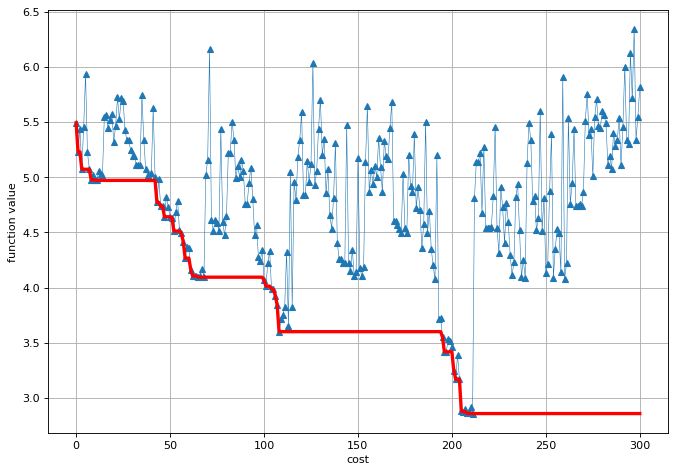

In [19]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.squeeze(np.array(history)[:, 1]), "^-", lw=0.5)
pl.xlabel("cost")
pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=3)
pl.ylabel("function value")
pl.grid(True)
# pl.ylim([0, 5]) 

## Minima of GD

In [20]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([ 0.1294, -0.0925,  0.8522, -0.3052,  0.1306,  0.0712,  0.3426,
         0.9058,  0.0445,  0.0735,  0.0475,  0.83  ,  0.1442,  1.0263,
         0.878 , -0.15  ,  0.9214,  0.9465, -0.0442, -0.1088]),
 2.8589818990863596,
 211)

In [21]:
gp.get_normal()

(4.779390878729634, 0.655605353543955)

In [22]:
sorted([(GDBO.min.item(), len(GDBO.history_w)) for GDBO in GD_House])

[(2.8589818990863596, 33),
 (3.6007667325308366, 20),
 (4.080050618130862, 19),
 (4.090551749342186, 27),
 (4.094013651514064, 38),
 (4.108514189300163, 22),
 (4.472553624665601, 17),
 (4.492825793437106, 12),
 (4.7357124695022925, 9),
 (4.756443060641452, 15),
 (4.841472544483306, 10),
 (4.865505082329825, 7),
 (4.9704523155575835, 10),
 (5.006847935424496, 11),
 (5.07646523596938, 7),
 (5.229545463827179, 7),
 (5.273388685397624, 7),
 (5.309453341668828, 4),
 (5.341401694894742, 1),
 (5.386672371979461, 1),
 (5.389894354301056, 1),
 (5.433902991042718, 1),
 (5.443950898324804, 1),
 (5.452876234824508, 1),
 (5.456402152677423, 1),
 (5.472533356805108, 1),
 (5.49098187566959, 1),
 (5.491472914125946, 1),
 (5.498881030861277, 1),
 (5.502220994425919, 1),
 (5.510150862483158, 1),
 (5.5240928935244575, 1),
 (5.532355395515847, 1),
 (5.587459250536984, 1),
 (5.59983417270098, 1),
 (5.621826538670202, 1),
 (5.6789674970054165, 1),
 (5.705282108122454, 1),
 (5.746287293956218, 1),
 (5.911070

In [23]:
# # only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# # pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### *Thompson Sampling, UCB*

In [24]:
### Thompson Sampling
import os
gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
# X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

history_ucb = []
for a in X_fix:
    history_ucb.append( (a, f(a)) )

In [ ]:
cost = setup + warmup

while cost < MAX:
    # 1. Thompson Sampling
    w = gp.thompson_sample(n_mesh=4000)
    # 2. GP_UCB
#     b = np.log(cost**gp.dim)
#     w, fw = gp.ucb_minimize(b)
#     w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
    if is_new(w, gp.X) == False:
        print('visit before, ignore ', w)
        continue
    

#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    print(cost, end = '. ')
    print('w: ', w)
    print('  f(w): ', f(w).item())
    print('  y_best: ', np.min(f(gp.X)))
    print()
    
    history_ucb.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

6. w:  [ 1.1155 -0.2267  1.2757  0.7424  1.1786  1.5002  0.7927  0.0947  0.3363
  0.5823 -0.3514 -0.018   1.9414 -0.1161 -0.1618  1.8639  1.7286  1.0503
  1.8308 -0.0578]
  f(w):  5.2782209400746325
  y_best:  5.071210248692243

  # Optimal (ls, var) =  (0.9581152292373389, 0.9999846758217923)
7. w:  [ 0.4068  1.8933 -0.3739  0.9879  1.2562  1.8266  1.917   0.5718  1.6009
  0.0175  1.9926  1.599   1.3198  0.0554  0.7082 -0.0648  0.1877  0.8891
  0.9357  1.8886]
  f(w):  5.803124658757042
  y_best:  5.071210248692243

8. w:  [ 0.7926 -0.1173  1.3718  0.0658  1.749   1.0247  1.8035  1.8404  0.9439
  1.2862 -0.3471  1.9787  1.8041  0.7832  0.0157 -0.1651 -0.2919  1.2275
  0.4352  1.2873]
  f(w):  5.595552336707186
  y_best:  5.071210248692243

9. w:  [ 1.7419  1.6297  1.9564  1.1072  0.1173 -0.4729 -0.2236  0.7413  0.1518
 -0.3947 -0.1293  0.5462  0.9108  0.3059  1.9584  0.327   1.2217 -0.2393
 -0.2302 -0.092 ]
  f(w):  5.083389020303116
  y_best:  5.071210248692243

  # Optimal (ls, var)

39. w:  [ 0.9158  0.3249  0.6744  1.6739  0.3176 -0.2844  1.8806  1.1949  1.8321
 -0.0976  0.8368  1.7194  1.1493  1.2981  1.9036  0.285   0.7224  0.4895
  1.7473  0.8362]
  f(w):  5.811474298363127
  y_best:  4.452511721950394

  # Optimal (ls, var) =  (0.506269930724768, 1.0000003189944326)
40. w:  [ 0.6297  0.1467  0.8902 -0.2976  0.4972  1.1734  0.5543  0.6041  1.5713
  1.3379 -0.3327 -0.3424  1.6965 -0.4761  1.6579  0.78    0.0818  0.6862
  1.8401  1.6515]
  f(w):  5.678902890412292
  y_best:  4.452511721950394

41. w:  [ 0.0546  0.3034  1.4028  0.6092  0.7427  1.0156  0.5596  0.8272  0.1007
  1.7979  1.9274  0.2865 -0.2871  1.9149 -0.0656  1.9042  0.4579 -0.3728
  1.0855  0.0402]
  f(w):  5.2113272678331874
  y_best:  4.452511721950394

42. w:  [ 1.5822 -0.119   1.7217  1.9831 -0.4494  1.6555  0.4572  1.7504  1.039
  0.3835 -0.1586  0.8795 -0.0167 -0.2099  1.8522  1.1287  0.16    0.4859
  1.9475 -0.0369]
  f(w):  5.625148546245139
  y_best:  4.452511721950394

  # Optimal (ls, va

72. w:  [ 0.2909  1.4524 -0.0532  0.23   -0.3074  1.7776  1.9009  1.9133  1.2604
  1.678   0.8689 -0.1562  0.892   1.3824  0.4972  0.6445  0.7889 -0.2377
  0.4155  0.6231]
  f(w):  5.583540205164656
  y_best:  4.452511721950394

  # Optimal (ls, var) =  (1.0, 0.9926754975497581)
73. w:  [-0.1427  0.6295  0.7196  1.338   1.8644  0.3858  1.2177 -0.2996  0.2085
  1.4086 -0.1174  0.1432  1.3756  0.6496 -0.3368 -0.3622  1.2961 -0.1338
  0.2295  0.6019]
  f(w):  5.002710376830251
  y_best:  4.452511721950394

74. w:  [ 1.6547  1.0272  0.2545  1.5654  1.5219  1.8556  1.5432  1.6971  0.663
 -0.2551 -0.0671  1.2067  0.6828  1.1986  0.0498  1.5753  1.1689  1.1973
  0.8622  0.3614]
  f(w):  5.927415608728651
  y_best:  4.452511721950394

75. w:  [ 1.7437  1.7332 -0.159   1.3014 -0.1393 -0.4572  1.6543  0.0979  1.0554
  0.2713  0.7335  1.8513 -0.4347  1.5928  1.2837  0.9436  0.9738  1.6567
  1.5928  0.5273]
  f(w):  5.964119139919259
  y_best:  4.452511721950394

  # Optimal (ls, var) =  (1.0, 0.9

104. w:  [ 0.8764  1.9605  0.0919  1.8184  1.6295 -0.2126  1.0306 -0.0747  0.004
  0.4286  0.9287  1.9415 -0.2468  0.5202  0.943  -0.1422  0.0662  0.0178
  1.8874 -0.0498]
  f(w):  4.759165802198034
  y_best:  4.452511721950394

105. w:  [ 1.2277  0.3546 -0.424   0.5447 -0.1455  0.7027 -0.2922  1.8871  0.9328
 -0.1654  0.2539  0.2059  0.1842  1.3511 -0.3209  0.3873  1.3804  0.0105
  0.377   0.0708]
  f(w):  4.563495466137841
  y_best:  4.452511721950394

  # Optimal (ls, var) =  (1.0, 0.9883529598206164)
106. w:  [-0.2516  0.7694  1.1961  0.9415  0.4692  0.5094  1.1545  0.2893 -0.0363
 -0.0803  0.7826 -0.3515  1.6407  0.4358  1.6359  0.8182  1.2294  0.6378
  0.7643  1.9462]
  f(w):  5.191320893367024
  y_best:  4.452511721950394

107. w:  [ 0.3496  1.8623  0.8303  0.5387 -0.2587  1.7094  1.1312 -0.0425  1.7893
  1.6056  1.8064  1.5627  0.8027  1.7864  1.4266  1.8554  0.458   0.0712
 -0.2436  1.0277]
  f(w):  6.072072435526405
  y_best:  4.452511721950394

108. w:  [ 0.3671  1.5588 -0.3

138. w:  [ 1.2341  1.4173  1.9137  0.7689  1.6431 -0.0092  0.4224  0.2382  0.9738
  0.4372  1.7851  0.8809  1.7433 -0.3101  1.1195  1.7074  0.7411  0.0836
 -0.2836 -0.3653]
  f(w):  5.605809191853776
  y_best:  4.420917380483765

  # Optimal (ls, var) =  (0.41650878192805885, 0.999999977341994)
139. w:  [-0.4363  1.9071  1.7674  1.3481  0.9103  1.9314  0.2511  0.0244  0.6567
  1.2511  1.1388 -0.1467  1.0515  1.8263  0.978   1.9829  0.2352  0.642
  0.5457 -0.0236]
  f(w):  5.518298222950705
  y_best:  4.420917380483765

140. w:  [ 1.574   0.4812  1.639   0.3783  0.0565  1.9904  1.5811  1.0138  0.4659
  1.2701  1.7693  0.7623  1.9185  1.4628  0.0636 -0.3212 -0.0677  0.9306
  0.3647  0.3395]
  f(w):  5.822475016128148
  y_best:  4.420917380483765

141. w:  [ 0.531  -0.0679  1.1575  0.2766  0.0448  0.5633  0.7489  1.2565  0.9607
  1.1251  1.9529  0.2236  0.9995 -0.0778  1.5016  0.7899  0.0783  1.9283
 -0.1909 -0.3491]
  f(w):  4.8371409442227
  y_best:  4.420917380483765

  # Optimal (ls, 

171. w:  [-0.396   0.5233  1.3205  0.8476  1.2246 -0.1426  1.1391  0.7499  0.346
  1.3676 -0.2932  1.0252  0.1378  0.6813  1.5587  1.4692  0.4397  0.3889
  0.5731  1.3253]
  f(w):  5.3161277405517
  y_best:  4.399928795681252

  # Optimal (ls, var) =  (0.3942111846470964, 1.0000000030692389)
172. w:  [-0.4767  1.8591 -0.0127  1.8869  1.6138  0.3618  1.1385  0.7938  0.7595
  0.6339  1.4303  1.7007  1.0099 -0.1367  0.2634 -0.4039  0.8626  0.686
  0.747  -0.1412]
  f(w):  5.379040256227633
  y_best:  4.399928795681252

173. w:  [ 0.1706  1.2498  0.4664  0.2363  0.4411  0.3762  0.5955  1.3494  0.3286
  1.5256  1.7639  0.2059 -0.3474  1.3173  0.4818  0.473   0.0588  0.2454
  0.9421  0.0763]
  f(w):  4.932504186014285
  y_best:  4.399928795681252

174. w:  [1.6138 1.9824 1.0904 1.8489 0.5819 0.312  1.5992 0.4159 1.2448 1.1533
 0.7384 0.2128 0.4583 1.9961 1.838  1.544  1.3895 0.8215 0.924  1.3233]
  f(w):  6.2849874537025805
  y_best:  4.399928795681252

  # Optimal (ls, var) =  (0.2224256862

204. w:  [ 1.9943  0.7074  1.9641  1.025   1.8514 -0.3348  0.5532  1.0657  1.7983
  1.2121  0.1109  1.245   1.6394  0.6743 -0.3499  1.4946  0.9469 -0.0751
  1.032   1.2153]
  f(w):  5.787892265477915
  y_best:  4.399928795681252

  # Optimal (ls, var) =  (0.1623215953513384, 1.0000006816467322)
205. w:  [-0.073   1.142   1.071   1.2132  1.5719 -0.0177 -0.2548  1.1054  0.3835
  1.4872  0.368  -0.331   0.5004  0.3037  1.1242  0.9015  1.9896 -0.2698
  1.56    1.8453]
  f(w):  5.479627037846171
  y_best:  4.399928795681252

206. w:  [ 1.1098  1.7059  1.5143  0.5362  1.8021 -0.0278  0.443  -0.1987  0.7948
 -0.0415  0.4842  0.6637  1.8717  0.0377  0.8827  1.3608  1.5862  0.9431
  0.2906  1.6632]
  f(w):  5.645405339517676
  y_best:  4.399928795681252

207. w:  [0.5482 1.9361 0.6265 0.434  1.7554 1.0621 0.8074 0.3091 1.432  0.5235
 0.5749 0.0842 1.0266 0.6627 1.196  1.6659 1.8952 1.0426 1.2919 1.614 ]
  f(w):  5.935186316155136
  y_best:  4.399928795681252

  # Optimal (ls, var) =  (0.0681772

237. w:  [ 0.8903  0.6916  1.0256  1.2194  0.0446  0.7953 -0.1771  1.1805  0.5916
  1.5216  1.9158  0.4393  1.8762  0.0793  1.0492  0.7235  0.5845  1.6725
 -0.1419  1.3983]
  f(w):  5.410284944153226
  y_best:  4.308290472995235

  # Optimal (ls, var) =  (0.16871311845397904, 1.0000000825146445)
238. w:  [-0.195  -0.0994  0.1473 -0.3118  1.657  -0.3702  1.837   1.1681  0.1191
  1.9555 -0.1985  1.3607  1.6476  1.4499  1.6315  1.3231  0.087   1.214
 -0.0807 -0.2807]
  f(w):  5.592473573318113
  y_best:  4.308290472995235

239. w:  [ 7.2850e-01  1.1337e+00  7.8024e-01  1.8870e+00  1.1881e-03  9.9337e-01
  4.5834e-01  1.3090e+00  1.3362e+00  8.5018e-01  1.7667e+00  8.2432e-01
 -6.6941e-02  1.1896e+00  6.1437e-01  7.1612e-01  1.3301e+00 -4.4108e-01
  1.8298e+00  1.5871e+00]
  f(w):  5.682618122420799
  y_best:  4.308290472995235

240. w:  [ 0.7412  1.2282  0.3963  0.0371  0.6878  1.955  -0.1388  0.4724 -0.4565
 -0.0265  0.4609  1.6439  1.5495  0.7749  1.9898  0.0443  1.8689 -0.0232
  0.2579

269. w:  [-0.2453  0.0931  0.1889 -0.2103  1.3333  1.1911  0.7485  1.52    0.8971
  0.7995 -0.4268  1.0872  0.2776  1.3741  1.1865  1.1582  1.6653  0.4326
  0.4428  1.998 ]
  f(w):  5.409782089505931
  y_best:  4.308290472995235

270. w:  [ 0.2468  0.7016  1.6468 -0.413   1.4175  1.8283 -0.1173  1.9682  1.0139
  0.4133 -0.259   1.7078  1.0283  1.8517  1.3739 -0.1716 -0.2404  0.6984
  1.3196  1.2767]
  f(w):  5.881836439109922
  y_best:  4.308290472995235

  # Optimal (ls, var) =  (1.0, 0.9664341820773888)
271. w:  [ 1.4825  1.6524 -0.2621  1.5469  0.7721  0.4494 -0.0696  0.7097 -0.2175
  0.2851  1.8946  1.4564  1.5762  1.5049  1.6469 -0.2562  0.8192  0.368
  1.9194 -0.4347]
  f(w):  6.098540565207006
  y_best:  4.308290472995235

272. w:  [ 1.1716  1.1711 -0.0373  1.0291 -0.4142  1.8463  1.6331 -0.3194  1.0997
  1.7027 -0.0181  0.2843  1.001   1.594   1.6147  0.347   0.216   0.4042
 -0.01   -0.0045]
  f(w):  5.24557219973963
  y_best:  4.308290472995235

273. w:  [-0.0921 -0.2134  0.44

In [ ]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.squeeze(np.array(history_ucb)[:, 1]), "-^", lw=0.5)
pl.plot(np.minimum.accumulate(np.array(history_ucb)[:, 1]), 'r', lw=2)
pl.xlabel("cost")
pl.ylabel("function value")
pl.grid(True)

## Global Minima 

In [ ]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

In [ ]:
gp.get_hyper()

In [ ]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.minimum.accumulate([t[1].item() for t in history_ucb]), 'r', lw=3, label='Thompson')
pl.plot(np.minimum.accumulate([t[1].item() for t in history]), 'b', lw=3, label='GD')
# pl.title("6D Hartmann function on [0, 1]")
pl.legend()
pl.grid(True)
# pl.ylim([0, 100])

In [ ]:
import pickle
file_name = "./pkl/GD_Ackley5.pkl" 

open_file = open(file_name, "wb")
pickle.dump(np.minimum.accumulate([t[1] for t in history]), open_file)
open_file.close()

open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

In [ ]:
file_name = "./pkl/thompson_Ackley5.pkl" 

open_file = open(file_name, "wb")
pickle.dump(np.minimum.accumulate([t[1] for t in history_ucb]), open_file)
open_file.close()

open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()